<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 50px"><b>But de ce Notebook</b></h2>
<p style="font-family: Arial, sans-serif; font-size: 20px; color: white;">
Dans ce notebook, nous allons segmenter la population française selon le sexe, l’âge et la région de résidence afin de réaliser une analyse détaillée de la sinistralité, laquelle sera systématiquement modélisée par le RAC (reste à charge) par personne.
</p>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Importation des librairies nécessaires</b></h2>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, norm, gamma, skewnorm
from sklearn.metrics import mean_absolute_percentage_error
from utils import get_demography_data_by_sexe_age_region
import warnings
warnings.simplefilter('ignore')

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Dictionnaires nécessaires</b></h2>

In [2]:
region_mapping = {
    5: "Régions et Départements d'outre-mer",
    11: "Ile-de-France",
    24: "Centre-Val-de-Loire et Pays de la Loire et Bourgogne-Franche-Comté",
    27: "Centre-Val-de-Loire et Pays de la Loire et Bourgogne-Franche-Comté",
    28: "Bretagne et Normandie",
    32: "Hauts-de-France et Grand Est",
    44: "Hauts-de-France et Grand Est",
    52: "Centre-Val-de-Loire et Pays de la Loire et Bourgogne-Franche-Comté",
    53: "Bretagne et Normandie",
    75: "Nouvelle-Aquitaine",
    76: "Occitanie",
    84: "Auvergne-Rhône-Alpes et Provence-Alpes-Côte d'Azur et Corse",
    93: "Auvergne-Rhône-Alpes et Provence-Alpes-Côte d'Azur et Corse"
}

age_mapping = {
    0:  "0 à 19 ans",
    20: "20 à 59 ans",
    30: "20 à 59 ans",
    40: "20 à 59 ans",
    50: "20 à 59 ans",
    60: "60+",
    70: "60+",
    80: "60+"
}

sexe_mapping = {
    1: "Hommes",
    2: "Femmes",

}

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Chargement des données de la DB OPEN DAMIR</b></h2>

In [3]:
df = pd.read_csv("../../page 3/RAC_nouveau_2.csv")
df = df.astype({
    'AGE_BEN_SNDS': 'int32',
    'BEN_SEX_COD': 'int32',
    'BEN_RES_REG': 'int32'
})


df.rename(columns = {'AGE_BEN_SNDS': "Tranche d'âge", 'BEN_RES_REG': 'Région', 'BEN_SEX_COD': 'Sexe', 'FLT_PAI_MNT': 'PAI', 'FLT_REM_MNT': 'REM', 'SOI_ANN': 'Annee', 'SOI_MOI': 'Mois'}, inplace = True)

df['Région'] = df['Région'].map(region_mapping)

df['Sexe'] = df['Sexe'].map(sexe_mapping)

df["Tranche d'âge"] = df["Tranche d'âge"].map(age_mapping)

df_grouped = df.drop(columns = ['PAI', 'REM', 'Mois']).groupby(by = ['Annee', 'Sexe', "Tranche d'âge", 'Région']).sum()

df_grouped.reset_index(inplace=True)

df_grouped = df_grouped[df_grouped['Annee'] >= 2019]

df_grouped

,Annee,Sexe,Tranche d'âge,Région,RAC
456,2019.0,Femmes,0 à 19 ans,Auvergne-Rhône-Alpes et Provence-Alpes-Côte d'...,4.491705e+08
457,2019.0,Femmes,0 à 19 ans,Bretagne et Normandie,1.963825e+08
458,2019.0,Femmes,0 à 19 ans,Centre-Val-de-Loire et Pays de la Loire et Bou...,2.708080e+08
459,2019.0,Femmes,0 à 19 ans,Hauts-de-France et Grand Est,3.649884e+08
460,2019.0,Femmes,0 à 19 ans,Ile-de-France,4.614121e+08
...,...,...,...,...,...
739,2024.0,Hommes,60+,Hauts-de-France et Grand Est,1.122859e+09
740,2024.0,Hommes,60+,Ile-de-France,1.062408e+09
741,2024.0,Hommes,60+,Nouvelle-Aquitaine,7.166692e+08
742,2024.0,Hommes,60+,Occitanie,6.948958e+08


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Interpolation mensuelle des données démographiques</b></h2>

In [4]:
def interpolate_population(data_1, data_2):
    # Copier les données des deux années pour éviter de modifier les originaux
    df_year_1 = data_1.copy()
    df_year_2 = data_2.copy()
    
    # Calculer la différence annuelle de population et la diviser par 12 pour obtenir les incréments mensuels
    difference_yearly_pop = ((df_year_2['Population'] - df_year_1['Population']) / 12).to_list()
    
    # Créer une liste des populations interpolées mensuellement
    df_year_2['Population_mensuelle'] = [
        [df_year_1['Population'].iloc[i] + j * difference_yearly_pop[i] for j in range(1, 13)]
        for i in range(len(df_year_1))
    ]
    df_year_2['Mois'] = list(range(1, 13) for _ in range(len(df_year_1))) 
    
    # Transformer les listes en lignes individuelles
    df_year_2 = df_year_2.explode(['Population_mensuelle', 'Mois']).reset_index(drop=True)

    # Supprimer la colonne 'population' car elle n'est plus nécessaire
    df_year_2.drop(columns=['Population'], inplace=True)

    # Trier les données par année et mois
    df_year_2.sort_values(by=['Mois', 'Sexe', "Tranche d'âge", "Région"])

    return df_year_2

# Interpoler les données pour toutes les années disponibles
def interpolate_all_data(year_population_dataframes):
    all_data = {}
    for year in range(2018, 2024): 
        # Récupérer les données de deux années consécutives
        data_1 = year_population_dataframes[year]
        data_2 = year_population_dataframes[year + 1]
        # Interpoler les données entre ces deux années
        all_data[year + 1] = interpolate_population(data_1, data_2)
    
    all_data_ = pd.concat(all_data.values())
    # Combiner toutes les données interpolées en un seul DataFrame
    return all_data_[['Annee', 'Mois', 'Sexe', "Tranche d'âge", 'Région', 'Population_mensuelle']]

# Appliquer l'interpolation à toutes les données démographiques
year_population_dataframes = {}
for year in range(2018, 2025): 
    year_population_dataframes[year] = get_demography_data_by_sexe_age_region.load_demography_data(year)


all_data = pd.concat(year_population_dataframes.values())
all_data[all_data['Annee'] == 2020]

,Annee,Région,Sexe,Tranche d'âge,Population
0,2020,Auvergne-Rhône-Alpes et Provence-Alpes-Côte d'...,Femmes,0 à 19 ans,1378685.7
1,2020,Auvergne-Rhône-Alpes et Provence-Alpes-Côte d'...,Femmes,20 à 59 ans,3039562.8
2,2020,Auvergne-Rhône-Alpes et Provence-Alpes-Côte d'...,Femmes,60+,1898612.1
3,2020,Auvergne-Rhône-Alpes et Provence-Alpes-Côte d'...,Hommes,0 à 19 ans,1454013.9
4,2020,Auvergne-Rhône-Alpes et Provence-Alpes-Côte d'...,Hommes,20 à 59 ans,2954682.9
5,2020,Auvergne-Rhône-Alpes et Provence-Alpes-Côte d'...,Hommes,60+,1505260.8
6,2020,Bretagne et Normandie,Femmes,0 à 19 ans,684283.5
7,2020,Bretagne et Normandie,Femmes,20 à 59 ans,1439730.0
8,2020,Bretagne et Normandie,Femmes,60+,990834.3
9,2020,Bretagne et Normandie,Hommes,0 à 19 ans,721788.3


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Fusion des données démographiques et des données de l'OPEN DAMIR</b></h2>

In [5]:
# on va merge les dataframes

copied_df = df_grouped.copy()
# Merge les dataframes sur 'annee', 'age', et 'sexe'.
final_df = copied_df.merge(all_data, how = 'right', on= ['Annee', 'Sexe', "Tranche d'âge", 'Région'], suffixes=('', '_new'))


final_df['RAC'] = final_df['RAC'].astype(float)

#final_df['Mois'] = final_df['Mois'].astype(int)


final_df['RAC_par_personne'] = final_df['RAC'] / final_df['Population'] 

final_df.dtypes

Annee               float64
Sexe                 object
Tranche d'âge        object
Région               object
RAC                 float64
Population          float64
RAC_par_personne    float64
dtype: object

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 40px"><b>Implémentation d'un GLM pour l'interprétation du RAC suivant le sexe, age et région du bénéficiaire</b></h2>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création de la base de données</b></h2>

In [6]:
def get_all_data_beginning_from_year(current_year, ending_year= 2024): 
    return final_df[(ending_year >= final_df['Annee']) & (final_df['Annee'] >= current_year)].sort_values(by=['Annee', 'Sexe', "Tranche d'âge", 'Région'])

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Choix de la loi de probabilité que suit la dérive de sinistralité</b></h2>

In [7]:
def get_hist_from_data_beginning_from_year(year): 
    df = get_all_data_beginning_from_year(year)
    sns.histplot(data=df, x="RAC_par_personne",stat="probability", common_norm=False, bins=20, kde=True, palette="crest", alpha=.5, element="step")
    plt.title(f'Histogramme du reste à charge par personne par mois à partir des données de l\'année {year}')
    return 


In [8]:
def get_q_q_plots(year):

    data = get_all_data_beginning_from_year(year)['RAC_par_personne'].astype(float)


    # Q-Q plot vs normal
    mu, sigma = stats.norm.fit(data)
    print(mu, sigma)
    stats.probplot(data, dist="norm", sparams=(mu, sigma), plot=plt)
    plt.title("Q-Q Plot vs Fitted Normal (μ, σ)")
    plt.grid()
    plt.show()


    # Q-Q plot vs gamma*
    params = stats.gamma.fit(data.to_list())
    print(params)
    fig = qqplot(data, dist=stats.gamma, distargs=params, line='45', fit=True, alpha=0.5, marker='o', markersize=5)
    plt.title("Q-Q Plot against Gamma Distribution")
    plt.grid()
    plt.show()

    # Q-Q plot vs Inverse Gaussian
    params = stats.invgauss.fit(data)
    print(params)
    fig = qqplot(data, dist=stats.invgauss, distargs=params, line='45', fit=True, alpha=0.5, marker='o', markersize=5)
    plt.title("Q-Q Plot against Inverse Gaussian Distribution")
    plt.grid()
    plt.show()

    # Q-Q plot vs Log-Normal
    params = stats.lognorm.fit(data)
    print(params)
    fig = qqplot(data, dist=stats.lognorm, distargs=params, line='45', fit=True, alpha=0.5, marker='o', markersize=5)
    plt.title("Q-Q Plot against Log-Normal Distribution")
    plt.grid()
    plt.show()

    return

529.5532462121797 261.55486994827345


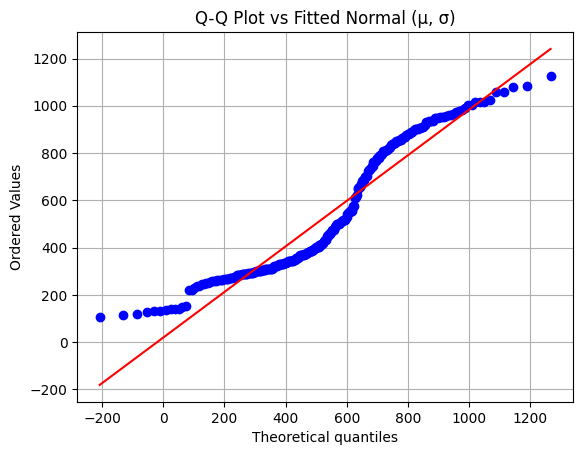

(np.float64(2.8487698506511223), np.float64(68.06708002705194), np.float64(161.99489968534166))


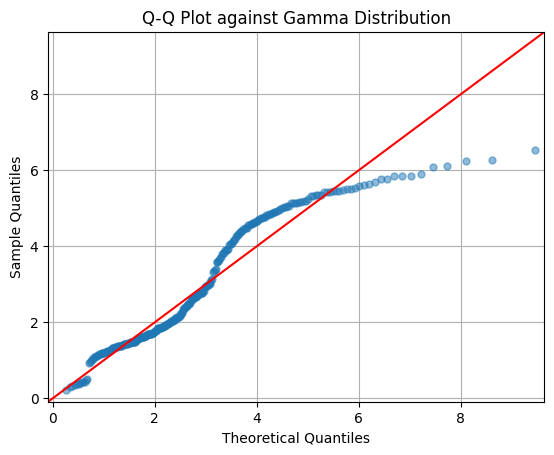

(np.float64(0.21656866118995738), np.float64(-71.72450357758417), np.float64(2765.283406008677))


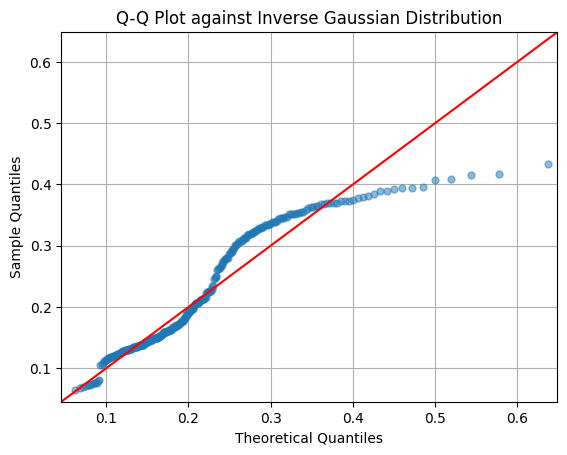

(np.float64(0.4604483438532888), -55.75654078494429, np.float64(528.1245430854133))


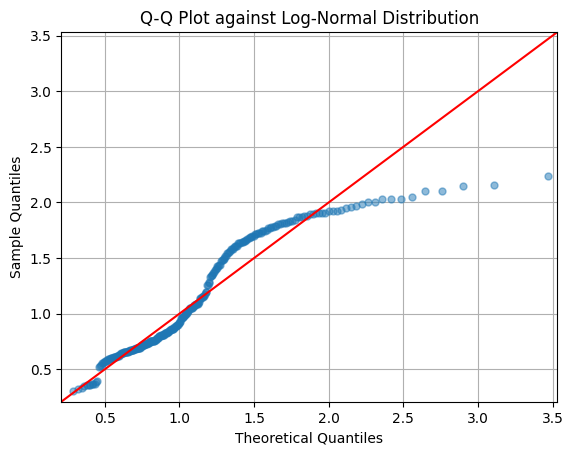

In [9]:
get_q_q_plots(2019)

In [10]:
def GLM_model(year, ending_year= 2024):

    df_GLM = get_all_data_beginning_from_year(year, ending_year)
    X = pd.get_dummies(df_GLM, columns = ['Région', 'Sexe', "Tranche d'âge"], drop_first = True,  dtype=int)
    X = sm.add_constant(X)
    y = X['RAC_par_personne']
    glm_model = sm.GLM(y, X.drop(columns=['RAC_par_personne', 'RAC', 'Population']), family=sm.families.Gaussian(sm.families.links.Identity()))
    glm_results = glm_model.fit()

    return glm_model, glm_results

In [11]:
glm_model, glm_results = GLM_model(year)

print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       RAC_par_personne   No. Observations:                   48
Model:                            GLM   Df Residuals:                       37
Model Family:                Gaussian   Df Model:                           10
Link Function:               Identity   Scale:                          1487.7
Method:                          IRLS   Log-Likelihood:                -237.18
Date:                Sat, 10 May 2025   Deviance:                       55045.
Time:                        19:52:28   Pearson chi2:                 5.50e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

In [12]:
# Extraire les coefficients et les p-values
coefficients = glm_results.params
p_values = glm_results.pvalues

# Créer un DataFrame pour résumer les résultats
summary_table = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values
})

# Ajouter une colonne pour le niveau de significativité
def significance_level(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

summary_table['Significance'] = summary_table['P-Value'].apply(significance_level)

# Afficher le tableau
summary_table

,Coefficient,P-Value,Significance
Annee,0.210376,1.152311e-117,***
Région_Bretagne et Normandie,-107.635419,1.341973e-06,***
Région_Centre-Val-de-Loire et Pays de la Loire et Bourgogne-Franche-Comté,-93.773147,2.543093e-05,***
Région_Hauts-de-France et Grand Est,-53.768727,1.575605e-02,**
Région_Ile-de-France,41.682185,6.123924e-02,*
Région_Nouvelle-Aquitaine,-48.790111,2.845541e-02,**
Région_Occitanie,-50.888601,2.230204e-02,**
Région_Régions et Départements d'outre-mer,-233.281725,1.117559e-25,***
Sexe_Hommes,-77.605696,3.172496e-12,***
Tranche d'âge_20 à 59 ans,157.077443,1.063524e-30,***
